In [1]:
from torchvision import models
from torchvision.transforms import transforms
import torch
import CitiesData
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time

In [2]:
# The inference transforms are available at ViT_B_16_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. 
# The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. 
# Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

#models.ViT_B_16_Weights.IMAGENET1K_V1
model_name = "vit_l_16_city"
model_image_size = 224
vit = models.vit_l_16(models.ViT_L_16_Weights.IMAGENET1K_V1)

C:\Users\inferno\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [3]:
class ViT(torch.nn.Module):
    def __init__(self, visionTransformer: models.VisionTransformer):
        super(ViT, self).__init__()
        
        self.reference_vit = visionTransformer
        self.reference_vit.heads.head = torch.nn.Linear(1024, 1024)
#         ViTLayers = torch.nn.Sequential(*list(visionTransformer.children())[:-1])

#         self.reference_vit.conv_proj.requires_grad = False
#         self.reference_vit.encoder.requires_grad = False
#         self.reference_vit.heads.requires_grad = False
#         self.reference_vit.heads.head.requires_grad = True
        
#         for param in self.reference_vit.parameters():
#             param.requires_grad = False

        #self.ViT = ViTLayers.to(device)
#         self.linear = torch.nn.Linear(1000, 10).to(device)
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512 ,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 10))
        self.softmax = torch.nn.Softmax(dim = 1)

    def forward(self, x):
        # Reshape and permute the input tensor
        x = self._process_input(x)
        n = x.shape[0]

        # Expand the class token to the full batch
        batch_class_token = self.reference_vit.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)

        x = self.reference_vit.encoder(x)

        # Classifier "token" as used by standard language architectures
        x = x[:, 0]

        x =  self.reference_vit.heads(x)
        
        #extractedFeature = self.ViT(x)
        x = self.layer(x)
        softmax = self.softmax(x)

        return softmax
    
    def _process_input(self, x: torch.Tensor) -> torch.Tensor:
        n, c, h, w = x.shape
        p = self.reference_vit.patch_size
        torch._assert(h == self.reference_vit.image_size, f"Wrong image height! Expected {self.reference_vit.image_size} but got {h}!")
        torch._assert(w == self.reference_vit.image_size, f"Wrong image width! Expected {self.reference_vit.image_size} but got {w}!")
        n_h = h // p
        n_w = w // p
        
        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x =  self.reference_vit.conv_proj(x)
        # (n, hidden_dim, n_h, n_w) -> (n, hidden_dim, (n_h * n_w))
        x = x.reshape(n, self.reference_vit.hidden_dim, n_h * n_w)

        # (n, hidden_dim, (n_h * n_w)) -> (n, (n_h * n_w), hidden_dim)
        # The self attention layer expects inputs in the format (N, S, E)
        # where S is the source sequence length, N is the batch size, E is the
        # embedding dimension
        x = x.permute(0, 2, 1)

        return x

In [4]:
visionTransformer = ViT(vit).to(device)
print(*list(visionTransformer.children())[:-1])

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

In [5]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(visionTransformer.parameters(), lr=1e-6)

In [6]:
batch_size = 32
transform = transforms.Compose([transforms.ToTensor(), transforms.RandomResizedCrop(size=(model_image_size, model_image_size), antialias=True), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainDataLoader, testDataLoader = CitiesData.getCitiesDataLoader("./Data/", transforms = transform, batchSize=batch_size)

In [7]:
print(len(trainDataLoader))
print(len(testDataLoader))
for i in trainDataLoader:
    image, cities, _, _ = i
    print(image.shape)
    break

6258
696
torch.Size([32, 3, 224, 224])


In [8]:
from fvcore.nn import FlopCountAnalysis
test_image = 0
for i in testDataLoader:
    test_image, cities, _, _ = i
    test_image = test_image.to(device)
    break
flops = FlopCountAnalysis(visionTransformer, test_image)
print(str(flops.total()) + " flops")
# Ignore Reds

Unsupported operator aten::mul encountered 97 time(s)
Unsupported operator aten::add encountered 49 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::unflatten encountered 24 time(s)
Unsupported operator aten::scaled_dot_product_attention encountered 24 time(s)
Unsupported operator aten::gelu encountered 24 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
reference_vit.encoder.layers.encoder_layer_0.self_attention.out_proj, reference_vit.encoder.layers.encoder_layer_1.self_attention.out_proj, reference_vit.encoder.layers.encoder_layer_10.self_attention.out_proj, reference_vit.encoder.layers.encoder_layer_11.self_att

1910346465280 flops


In [9]:
def evaluate_on_data(vit, dataloader, criterion):
    with torch.no_grad():
        total_loss = 0
        
        num_correct = 0.0
        num_samples = 0.0
        for data in dataloader:
            image, city, _, _ = data
            city = city.to(device)
            image = image.to(device)
            outputs = vit(image)
            loss = criterion(outputs, city)
            total_loss += loss.item()
            for i in range(len(city)):

                model_vote = 0
                answer = 0
                for j in range(len(outputs[i])):
                    if outputs[i][j] > outputs[i][model_vote]:
                        model_vote = j
                    if city[i][j] == 1:
                        answer = j
                
                if answer == model_vote:
                    num_correct += 1
                num_samples += 1
                    
                
                
    return total_loss / len(dataloader), num_correct / num_samples

In [10]:
num_epochs = 15
count = 0
test_loss_array = np.zeros(num_epochs)
test_acc_array = np.zeros(num_epochs)
train_loss_array = np.zeros(num_epochs)
for epoch in range(num_epochs):
    start = time.time()
    batch_count = 0
    for data in trainDataLoader:
        
        image, city, _, _ = data
        
        city = city.to(device)
        image = image.to(device)

        optimizer.zero_grad()
        outputs = visionTransformer(image)
        loss = criterion(outputs, city)
        loss.backward()
        optimizer.step()
        
        end = time.time()
        count += 1
        print(str(int(end-start)) + " sec " + str(count * batch_size) + " images " + str(loss.item()) + " loss", end='\x1b\r')
        
        batch_count += 1
        if batch_count > len(trainDataLoader) / 5.0:
            test_loss, test_acc = evaluate_on_data(visionTransformer, testDataLoader, criterion)
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Test Loss: {test_loss}, Test ACC: {test_acc}')
            test_loss_array[epoch] = test_loss
            train_loss_array[epoch] = loss.item()
            test_acc_array[epoch] = test_acc
            batch_count = 0
            
        
    test_loss, test_acc = evaluate_on_data(visionTransformer, testDataLoader, criterion)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Test Loss: {test_loss}, Test ACC: {test_acc}')
    test_loss_array[epoch] = test_loss
    train_loss_array[epoch] = loss.item()
    test_acc_array[epoch] = test_acc
    

Epoch [1/15], Training Loss: 1.6605, Test Loss: 1.8536929813930871, Test ACC: 0.6069309600862999
Epoch [2/15], Training Loss: 1.8968, Test Loss: 1.8287099473574466, Test ACC: 0.6232470334412082
Epoch [3/15], Training Loss: 1.8654, Test Loss: 1.747959927762805, Test ACC: 0.7159744696152464
Epoch [4/15], Training Loss: 1.4615, Test Loss: 1.7295967721294654, Test ACC: 0.731032002876663
Epoch [5/15], Training Loss: 1.6785, Test Loss: 1.7205644233430597, Test ACC: 0.7400215749730313
Epoch [6/15], Training Loss: 1.8368, Test Loss: 1.715191788420124, Test ACC: 0.7453703703703703
Epoch [7/15], Training Loss: 1.6612, Test Loss: 1.7204361795875962, Test ACC: 0.740111470693995
Epoch [8/15], Training Loss: 1.4656, Test Loss: 1.7163640534098463, Test ACC: 0.7446961524631428
Epoch [9/15], Training Loss: 1.4612, Test Loss: 1.697979647318308, Test ACC: 0.7623157137720245
Epoch [10/15], Training Loss: 1.4613, Test Loss: 1.7108582952434475, Test ACC: 0.7494606256742179
Epoch [11/15], Training Loss: 1.46

In [11]:
with open(model_name + '_test.npy', 'wb') as f:
    np.save(f, test_loss_array)
    
with open(model_name + '_test_acc.npy', 'wb') as f:
    np.save(f, test_acc_array)
    
with open(model_name + '_train.npy', 'wb') as f:
    np.save(f, train_loss_array)

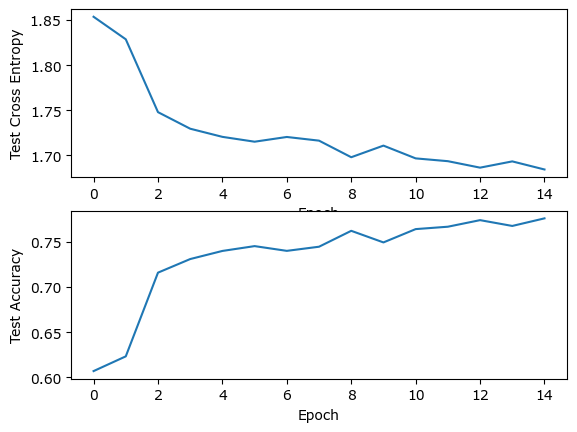

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2)
# this locator puts ticks at regular intervals

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Test Cross Entropy")
ax[0].plot(range(len(test_loss_array)), test_loss_array)

ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Test Accuracy")
ax[1].plot(range(len(test_acc_array)),test_acc_array)

In [13]:
print(visionTransformer.layer.params)

AttributeError: 'Sequential' object has no attribute 'params'